# Comparative Analysis of LSB Variants in Image Steganography

### Introduction
This notebook explores five different Least Significant Bit (LSB) steganography variants for hiding secret messages within an image. The methods included are:
1. Basic 1-bit LSB
2. 2-bit LSB
3. LSB-Matching
4. Adaptive LSB
5. Edge-Based LSB

We'll compare these techniques using PSNR (Peak Signal-to-Noise Ratio) to evaluate image quality after encoding.

In [13]:

from PIL import Image
import numpy as np
import cv2
import math
import random
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from ipywidgets import interact, widgets
from IPython.display import display

## Utility Functions

In [14]:
def text_to_bin(data):
    data += "####"
    return ''.join([format(ord(i), '08b') for i in data])

def bin_to_text(binary_data):
    all_bytes = [binary_data[i:i+8] for i in range(0, len(binary_data), 8)]
    message = ''.join([chr(int(byte, 2)) for byte in all_bytes])
    terminator_index = message.find("####")
    if terminator_index != -1:
        return message[:terminator_index]
    return message

### 1. Basic 1-bit LSB

In [15]:
def basic_lsb_encode(img, data):
    img_data = np.array(img)
    binary_data = text_to_bin(data)  # Binary data includes terminator
    data_len = len(binary_data)
    idx = 0
    for row in img_data:
        for pixel in row:
            for channel in range(3):  # RGB channels
                if idx < data_len:
                    pixel[channel] = int(bin(pixel[channel])[2:-1] + binary_data[idx], 2)
                    idx += 1
    return Image.fromarray(img_data)

def basic_lsb_decode(img):
    img_data = np.array(img)
    binary_data = ''
    for row in img_data:
        for pixel in row:
            for channel in range(3):
                binary_data += bin(pixel[channel])[-1]
    return bin_to_text(binary_data)


### 2. 2-bit LSB

In [16]:

def lsb_2bit_encode(img, data):
    img_data = np.array(img)
    binary_data = text_to_bin(data)
    data_len = len(binary_data)
    idx = 0
    for row in img_data:
        for pixel in row:
            for channel in range(3):
                if idx < data_len - 1:
                    pixel[channel] = int(bin(pixel[channel])[2:-2] + binary_data[idx:idx+2], 2)
                    idx += 2
    return Image.fromarray(img_data)

def lsb_2bit_decode(img):
    img_data = np.array(img)
    binary_data = ''
    for i in range(img_data.shape[0]):
        for j in range(img_data.shape[1]):
            for channel in range(3):
                # Extract only the last two bits and remove '0b' prefix
                binary_data += bin(img_data[i, j, channel])[2:][-2:].zfill(2)  # Pad with leading zeros if necessary
    return bin_to_text(binary_data)

### 3. LSB-Matching (±1 LSB)

In [17]:

def lsb_matching_encode(img, data):
    img_data = np.array(img)
    binary_data = text_to_bin(data)
    data_len = len(binary_data)
    idx = 0
    for row in img_data:
        for pixel in row:
            for channel in range(3):
                if idx < data_len:
                    bit = int(binary_data[idx])
                    if pixel[channel] % 2 != bit:
                        pixel[channel] = pixel[channel] - 1 if random.choice([True, False]) else pixel[channel] + 1
                    idx += 1
    return Image.fromarray(img_data)

def lsb_matching_decode(img):
    img_data = np.array(img)
    binary_data = ''
    for row in img_data:
        for pixel in row:
            for channel in range(3):
                binary_data += str(pixel[channel] % 2)
    return bin_to_text(binary_data)


### 4. Adaptive LSB

In [18]:
def adaptive_lsb_encode(img, data):
    img_data = np.array(img)
    binary_data = text_to_bin(data)
    data_len = len(binary_data)
    idx = 0
    for row in img_data:
        for pixel in row:
            bits_to_use = 1 if sum(pixel[:3]) / 3 < 128 else 2
            for channel in range(3):
                if idx < data_len - bits_to_use + 1:
                    pixel[channel] = int(bin(pixel[channel])[:-bits_to_use] + binary_data[idx:idx+bits_to_use], 2)
                    idx += bits_to_use
    return Image.fromarray(img_data)

def adaptive_lsb_decode(img):
    img_data = np.array(img)
    binary_data = ''
    for row in img_data:
        for pixel in row:
            bits_to_use = 1 if sum(pixel[:3]) / 3 < 128 else 2
            for channel in range(3):
                binary_data += bin(pixel[channel])[-bits_to_use:]
    return bin_to_text(binary_data)


### 5. Edge-Based LSB

In [19]:

def edge_based_lsb_encode(img, data):
    img_data = np.array(img)
    binary_data = text_to_bin(data)
    data_len = len(binary_data)
    idx = 0
    edges = cv2.Canny(img_data, 100, 200)
    for i in range(edges.shape[0]):
        for j in range(edges.shape[1]):
            if edges[i, j] == 255:
                for channel in range(3):
                    if idx < data_len:
                        img_data[i, j, channel] = int(bin(img_data[i, j, channel])[2:-1] + binary_data[idx], 2)
                        idx += 1
    return Image.fromarray(img_data)

def edge_based_lsb_decode(img):
    img_data = np.array(img)
    binary_data = ''
    edges = cv2.Canny(img_data, 100, 200)
    for i in range(edges.shape[0]):
        for j in range(edges.shape[1]):
            if edges[i, j] == 255:
                for channel in range(3):
                    binary_data += bin(img_data[i, j, channel])[-1]
    return bin_to_text(binary_data)


## Evaluation Metric: PSNR Calculation

In [20]:
def calculate_psnr(original_img, encoded_img):
    original = np.array(original_img, dtype=np.float64)
    encoded = np.array(encoded_img, dtype=np.float64)
    mse = np.mean((original - encoded) ** 2)
    if mse == 0:
        return float('inf')  # Perfectly identical images
    return 20 * math.log10(255.0 / math.sqrt(mse))

## Evaluation Metric: SSIM Calculation

In [21]:
# Calculate SSIM
def calculate_ssim(original, modified):
    original = np.array(original.convert("L"))
    modified = np.array(modified.convert("L"))
    # Use ssim function correctly
    return ssim(original, modified)

## Execution and Comparison

## 4. Comparative Visualizations

In [22]:
def show_side_by_side(original, encoded, title1="Original", title2="Encoded"):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(original)
    axs[0].set_title(title1)
    axs[0].axis("off")

    axs[1].imshow(encoded)
    axs[1].set_title(title2)
    axs[1].axis("off")

    plt.show()


## 6. Interactive Steganography Experiment

FileUpload(value={}, accept='image/*', description='Upload')

Text(value='', description='Message:')

Dropdown(description='LSB Variant:', options=('Basic 1-bit LSB', '2-bit LSB', 'LSB-Matching', 'Adaptive LSB', …

Button(description='Encode & Display', style=ButtonStyle())

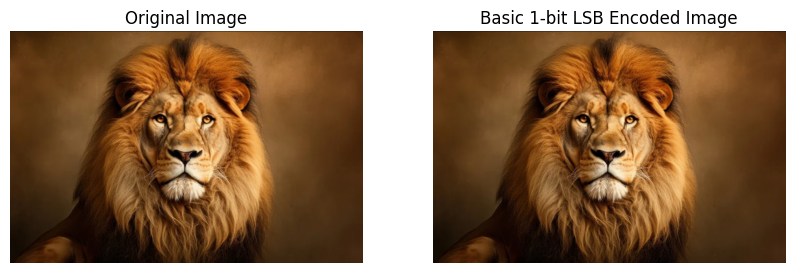

PSNR: 100.54 dB
SSIM: 0.9999999966491504


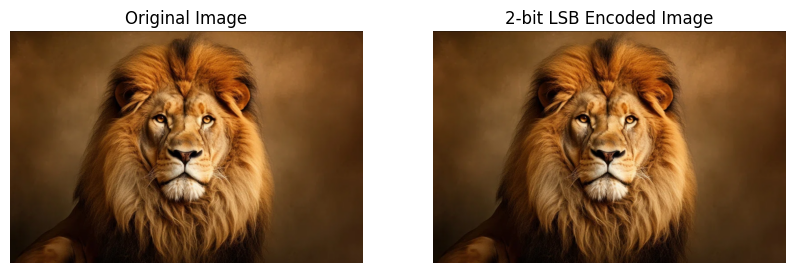

PSNR: 89.89 dB
SSIM: 0.9999999744939101


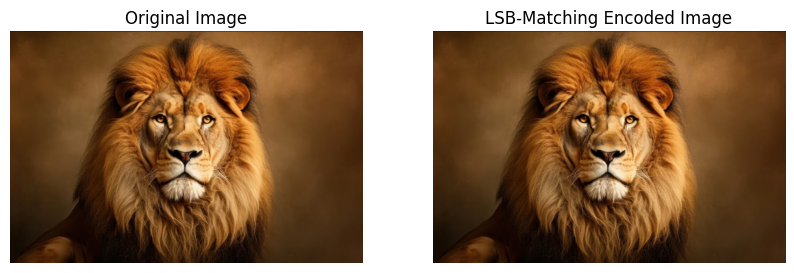

PSNR: 94.30 dB
SSIM: 0.9999999895186922


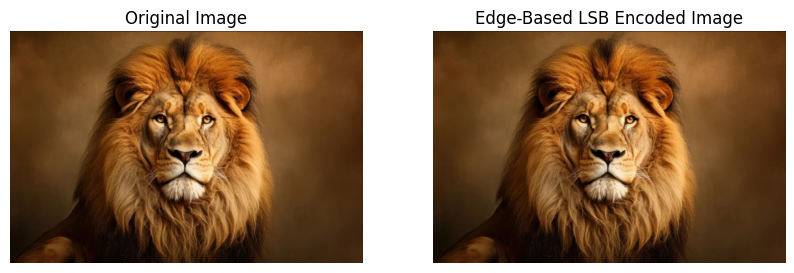

PSNR: 94.30 dB
SSIM: 0.9999999822269446


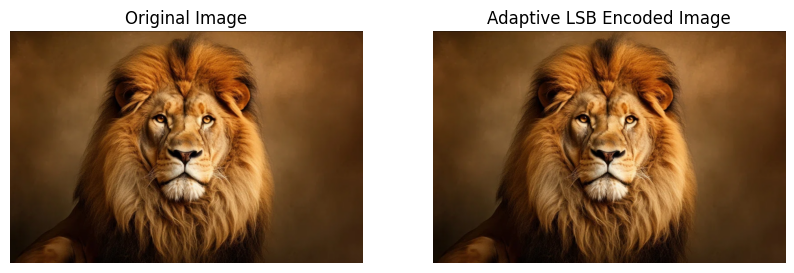

PSNR: 94.30 dB
SSIM: 0.9999999831434458


In [23]:

# Interactive function for user to select image, message, and LSB variant
def interactive_lsb_steganography():
    variants = ["Basic 1-bit LSB", "2-bit LSB", "LSB-Matching", "Adaptive LSB", "Edge-Based LSB"]

    # Widgets for user input
    image_input = widgets.FileUpload(accept='image/*', multiple=False)
    message_input = widgets.Text(value='', description="Message:")
    variant_input = widgets.Dropdown(options=variants, description="LSB Variant:")
    encode_button = widgets.Button(description="Encode & Display")

    display(image_input, message_input, variant_input, encode_button)

    def on_button_click(b):
        if image_input.value and message_input.value:
            # Load image
            img_data = list(image_input.value.values())[0]['content']
            with open("temp_image.png", "wb") as f:
                f.write(img_data)
            img = Image.open("temp_image.png")

            variant = variant_input.value
            if variant == "Basic 1-bit LSB":
                encoded_img = basic_lsb_encode(img, message_input.value)
            elif variant == "2-bit LSB":
                encoded_img = lsb_2bit_encode(img, message_input.value)
            elif variant == "LSB-Matching":
                encoded_img = lsb_matching_encode(img, message_input.value)
            elif variant == "Adaptive LSB":
                encoded_img = adaptive_lsb_encode(img, message_input.value)
            elif variant == "Edge-Based LSB":
                encoded_img = edge_based_lsb_encode(img, message_input.value)

            show_side_by_side(img, encoded_img, title1="Original Image", title2=(f"{variant} Encoded Image"))

            psnr_value = calculate_psnr(img, encoded_img)
            ssim_value = calculate_ssim(img, encoded_img)
            print(f"PSNR: {psnr_value:.2f} dB")
            print(f"SSIM: {ssim_value:}")

    encode_button.on_click(on_button_click)

interactive_lsb_steganography()


In [24]:
input_image_path = "marshall.png"
input_image = Image.open(input_image_path).convert("RGB")
secret_message = "Our Dps madam is Dr. Swathi Hira ma'am"

variants = [
    ("Basic LSB", basic_lsb_encode, basic_lsb_decode),
    ("2-bit LSB", lsb_2bit_encode, lsb_2bit_decode),
    ("LSB Matching", lsb_matching_encode, lsb_matching_decode),
    ("Adaptive LSB", adaptive_lsb_encode, adaptive_lsb_decode),
    ("Edge-Based LSB", edge_based_lsb_encode, edge_based_lsb_decode),
]

for name, encode_func, decode_func in variants:
    encoded_image = encode_func(input_image, secret_message)
    decoded_message = decode_func(encoded_image)
    psnr = calculate_psnr(input_image, encoded_image)
    print(f"{name} Encoding:")
    print(f"Decoded Message: {decoded_message}")
    print(f"PSNR: {psnr} dB")
    print("  ")
    encoded_image.save(f"{name.replace(' ', '_').lower()}_encoded.png")

Basic LSB Encoding:
Decoded Message: Our Dps madam is Dr. Swathi Hira ma'am
PSNR: 92.34510400542875 dB
  
2-bit LSB Encoding:
Decoded Message: Our Dps madam is Dr. Swathi Hira ma'am
PSNR: 88.4353517200366 dB
  
LSB Matching Encoding:
Decoded Message: Our Dps madam is Dr. Swathi Hira ma'am
PSNR: 92.34510400542875 dB
  
Adaptive LSB Encoding:
Decoded Message: Our Dps madam is Dr. Swathi Hira ma'am
PSNR: 92.34510400542875 dB
  
Edge-Based LSB Encoding:
Decoded Message: Our Dps madam is Dr. Swathi Hira ma'am
PSNR: 92.86898470002563 dB
  


Results and Analysis
The experimental results highlight the trade-offs between embedding capacity, image quality, and detectability of each LSB method:
- 1-bit LSB: Maintained high PSNR and SSIM values, indicating minimal distortion, but had limited capacity for large messages.
- 2-bit LSB: Increased data capacity but reduced PSNR and SSIM, indicating more noticeable image alterations.
- LSB-Matching: Achieved moderate PSNR and SSIM, balancing capacity and security by reducing detection risks.
- Adaptive LSB: Delivered higher capacity in complex image areas while preserving quality, though PSNR varied based on image complexity.
- Edge-Based LSB: Maintained image quality due to targeted edge modifications, achieving relatively high PSNR and SSIM values.